<a href="https://colab.research.google.com/github/kiran-lenka/TweetSense/blob/main/TweetSense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Classification from Social Media during pandemic


#Import Libraries 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import gdown

# Natural Language Processing
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from nltk.corpus import stopwords

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Data Cleaning function


In [ ]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='tweet', inplace=True)
    
    # Drop Null entries
    dataframe.dropna(inplace=True)

    # Transform all text to lowercase
    dataframe['tweet'] = dataframe['tweet'].str.lower()
    
    # Remove punctation
    dataframe['tweet'] = dataframe['tweet'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['tweet'] = dataframe['tweet'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['tweet'] = dataframe['tweet'].str.replace('  ',' ')
    dataframe['tweet'] = dataframe['tweet'].str.replace('  ',' ')

    return dataframe

##Importing data and cleaning

In [ ]:
gdown.download('https://drive.google.com/uc?id=1GqtuVHDnZ4RaDFCfQnD09_U8W8iOcRys','TweetsDataset.csv',quiet=False)
df = pd.read_csv('TweetsDataset.csv', header = 0)
clean_data(df)
df.drop(columns=['id'], inplace = True)
print("Data shape: ",df.shape)
print(df['label'].value_counts())

Downloading...
From: https://drive.google.com/uc?id=1GqtuVHDnZ4RaDFCfQnD09_U8W8iOcRys
To: /content/TweetsDataset.csv
100%|██████████| 196k/196k [00:00<00:00, 65.7MB/s]

Data shape:  (921, 2)
Irrelevant    427
Report        285
Awareness     137
Treatment      72
Name: label, dtype: int64


###Upsampling for the lowest two classes
 

In [ ]:
from sklearn.utils import resample
df_treatment = df[df['label']=='Treatment']
df_awareness = df[df['label']=='Awareness']
df_others = df[df['label']!='Treatment']
df_upsampled_t = resample(df_treatment,replace = True,n_samples = 250, random_state=42)
df_upsampled_a = resample(df_awareness,replace = True,n_samples = 220, random_state=42)
df = pd.concat([df_others,df_upsampled_t,df_upsampled_a])
print(df['label'].value_counts())

Irrelevant    427
Awareness     357
Report        285
Treatment     250
Name: label, dtype: int64


In [ ]:
tweet = df['tweet'].str.cat(sep=' ')
tweet = tweet.lower()
tokens = word_tokenize(tweet)
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words and w.isalpha()]
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

['covid',
 'coronavirus',
 'people',
 'us',
 'cases',
 'new',
 'spread',
 'virus',
 'treatment',
 'health',
 'home',
 'today',
 'positive',
 'tested',
 'help',
 'need',
 'days',
 'stay',
 'time',
 'patients',
 'remdesivir',
 'test',
 'get',
 'breaking',
 'take',
 'one',
 'please',
 'pandemic',
 'testing',
 'trump',
 'symptoms',
 'news',
 'like',
 'social',
 'first',
 'coronavirusoutbreak',
 'must',
 'protect',
 'everyone',
 'public',
 'vaccine',
 'fight',
 'cure',
 'emergency',
 'medical',
 'china',
 'trial',
 'support',
 'pm',
 'show']

###A visual representation of the vocabulary scaled to frequency

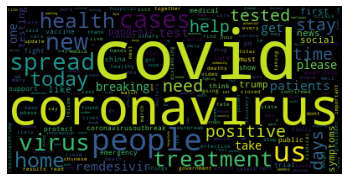

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Customised Bar Plot Function

In [ ]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g = sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

Changing the tag notation from string to numeric

In [ ]:
 my_tags = ['Awareness', 'Irrelevant', 'Report', 'Treatment']
Encoder = LabelEncoder()
df['label'] = Encoder.fit_transform(df['label'])
print(df['label'].unique())
name_mapping = dict(zip(Encoder.classes_, Encoder.transform(Encoder.classes_)))
print(name_mapping)


[0 1 2 3]
{'Awareness': 0, 'Irrelevant': 1, 'Report': 2, 'Treatment': 3}


# Natural Language Processing (NLP)

###Using Count Vectorizer  explore the most used words and combinations of words from each category 

###**Ngram Range = (1,1)**

*   For the Awareness label

In [ ]:
mask_no = df['label'] == 0
awareness_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer = CountVectorizer(stop_words = 'english')
cv_awareness = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_awareness = cv_awareness.fit_transform(awareness_tweets)

# Convert into a DataFrame
cvec_awareness_df = pd.DataFrame(cvec_awareness.toarray(),columns=cv_awareness.get_feature_names())

# Inspect head 
print(cvec_awareness_df.shape) 

(357, 1228)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


*    For the report label




In [ ]:
mask_no = df['label'] == 2
report_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_report = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_report = cv_report.fit_transform(report_tweets)

# Convert into a DataFrame
cvec_report_df = pd.DataFrame(cvec_report.toarray(),
                   columns=cv_report.get_feature_names())

# Inspect head 
print(cvec_report_df.shape)

(285, 2335)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



*   For the Treatment label



In [ ]:
mask_no = df['label'] == 3
treatment_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_treatment = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_treatment = cv_treatment.fit_transform(treatment_tweets)

# Convert into a DataFrame
cvec_treatment_df = pd.DataFrame(cvec_treatment.toarray(),
                   columns=cv_treatment.get_feature_names())

# Inspect head 
print(cvec_treatment_df.shape)

(250, 811)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



*   For the Irrelevant label



In [ ]:
mask_no = df['label'] == 1
irrelevant_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_irrelevant = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_irrelevant = cv_irrelevant.fit_transform(irrelevant_tweets)

# Convert into a DataFrame
cvec_irrelevant_df = pd.DataFrame(cvec_irrelevant.toarray(),
                   columns=cv_irrelevant.get_feature_names())

# Inspect head 
print(cvec_irrelevant_df.shape)

(427, 3198)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Set up variables to figure out top 10 unigrams in Each label

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


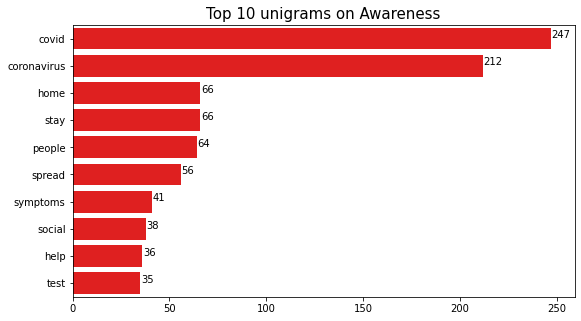

In [ ]:
#Awareness Label
wc_A = cvec_awareness_df.sum(axis = 0)
awareness_top10 = wc_A.sort_values(ascending=False).head(10)
bar_plot(awareness_top10.values, awareness_top10.index, 'Top 10 unigrams on Awareness','r') 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


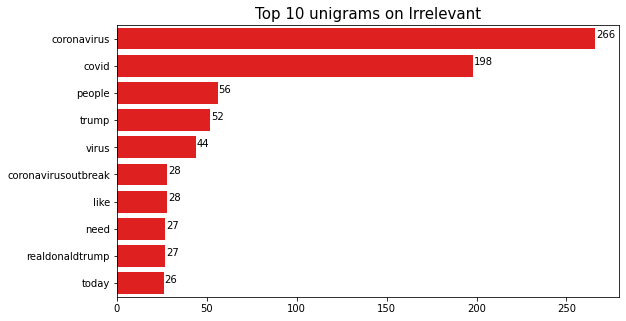

In [ ]:
#Irrelevant Label
wc_I = cvec_irrelevant_df.sum(axis = 0)
irrelevant_top10 = wc_I.sort_values(ascending=False).head(10)
bar_plot(irrelevant_top10.values, irrelevant_top10.index, 'Top 10 unigrams on Irrelevant','r')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


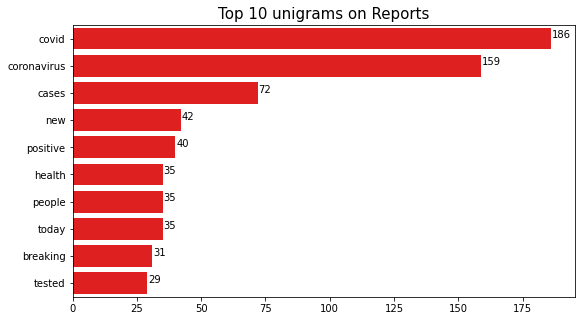

In [ ]:
#Report Label
wc_R = cvec_report_df.sum(axis = 0)
report_top10 = wc_R.sort_values(ascending=False).head(10)
bar_plot(report_top10.values, report_top10.index, 'Top 10 unigrams on Reports','r')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


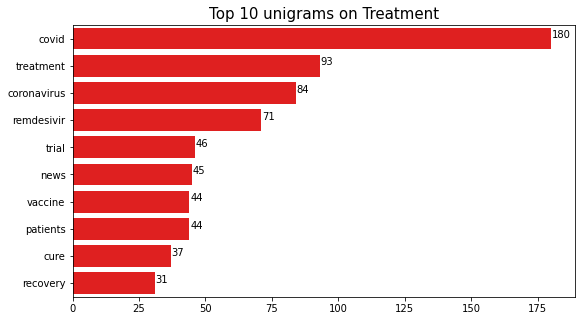

In [ ]:
#Treatment Label
wc_T = cvec_treatment_df.sum(axis = 0)
treatment_top10 = wc_T.sort_values(ascending=False).head(10)
bar_plot(treatment_top10.values, treatment_top10.index, 'Top 10 unigrams on Treatment','r')

### Common Unigrams between Top 10 in each label

In [ ]:
# Create list of unique words in top ten
awareness_set = set(awareness_top10.index)
irrelevant_set = set(irrelevant_top10.index)
report_set = set(report_top10.index)
treatment_set = set(treatment_top10.index)

# Return common words
common_unigrams = awareness_set.intersection(irrelevant_set.intersection(report_set.intersection(treatment_set)))
common_unigrams

{'coronavirus', 'covid'}

###**Ngram Range = (2,2)**

*  For the Awareness label

In [ ]:
mask_on = df['label'] == 0
awareness_tweets = df[mask_on]['tweet']

# Instantiate a CountVectorizer
cv_awareness = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_awareness = cv_awareness.fit_transform(awareness_tweets)

# Convert into a DataFrame
cvec_awareness_df = pd.DataFrame(cvec_awareness.toarray(),
                   columns=cv_awareness.get_feature_names())

# Inspect head 
print(cvec_awareness_df.shape) 

(357, 2070)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



*  For the Irrelevant label


In [ ]:
mask_no = df['label'] == 1
irrelevant_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_irrelevant = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_irrelevant = cv_irrelevant.fit_transform(irrelevant_tweets)

# Convert into a DataFrame
cvec_irrelevant_df = pd.DataFrame(cvec_irrelevant.toarray(),
                   columns=cv_irrelevant.get_feature_names())

# Inspect head 
print(cvec_irrelevant_df.shape)


(427, 5867)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



*  For the Report label


In [ ]:
mask_no = df['label'] == 2
report_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_report = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_report = cv_report.fit_transform(report_tweets)

# Convert into a DataFrame
cvec_report_df = pd.DataFrame(cvec_report.toarray(),
                   columns=cv_report.get_feature_names())

# Inspect head 
print(cvec_report_df.shape)

(285, 4432)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



*  For the Treatment label


In [ ]:
mask_no = df['label'] == 3
treatment_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_treatment = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_treatment = cv_treatment.fit_transform(treatment_tweets)

# Convert into a DataFrame
cvec_treatment_df = pd.DataFrame(cvec_treatment.toarray(),
                   columns=cv_treatment.get_feature_names())

# Inspect head 
print(cvec_treatment_df.shape)

(250, 1217)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Set up variables to figure out top 10 bigrams in Each label

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


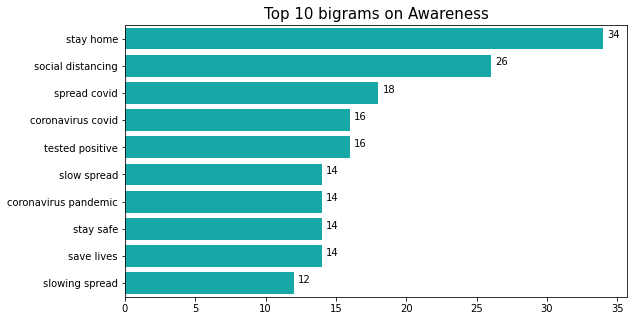

In [ ]:
# Awareness label
wc_A = cvec_awareness_df.sum(axis = 0)
awareness_top10 = wc_A.sort_values(ascending=False).head(10)
bar_plot(awareness_top10.values, awareness_top10.index, 'Top 10 bigrams on Awareness','c') 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


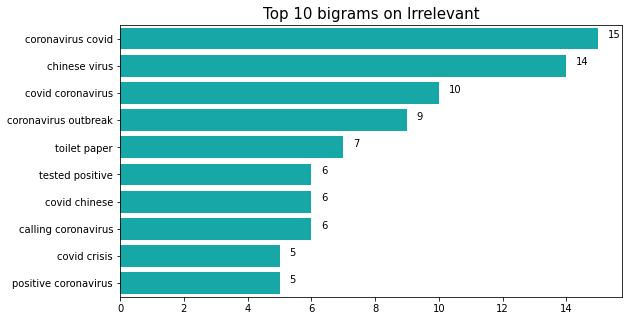

In [ ]:
#Irrelevant label
wc_I = cvec_irrelevant_df.sum(axis = 0)
irrelevant_top10 = wc_I.sort_values(ascending=False).head(10)
bar_plot(irrelevant_top10.values, irrelevant_top10.index, 'Top 10 bigrams on Irrelevant','c')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


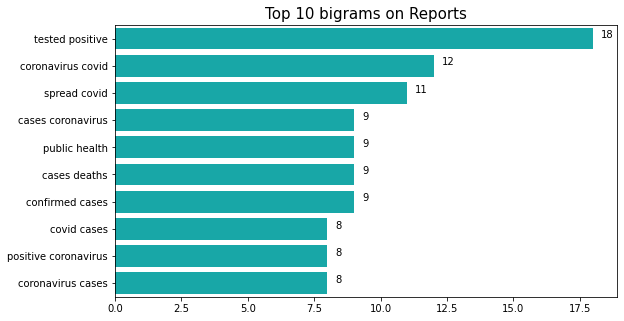

In [ ]:
wc_R = cvec_report_df.sum(axis = 0)
report_top10 = wc_R.sort_values(ascending=False).head(10)
bar_plot(report_top10.values, report_top10.index, 'Top 10 bigrams on Reports','c')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


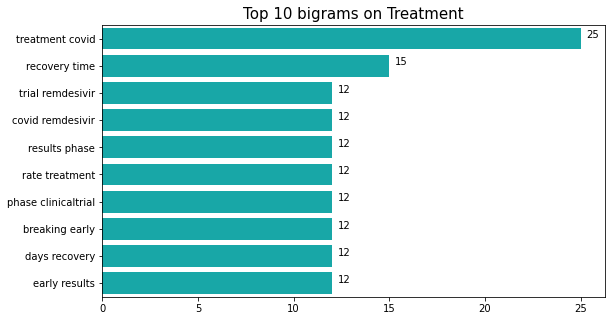

In [ ]:
# Treatment label
wc_T = cvec_treatment_df.sum(axis = 0)
treatment_top10 = wc_T.sort_values(ascending=False).head(10)
bar_plot(treatment_top10.values, treatment_top10.index, 'Top 10 bigrams on Treatment','c')

###Common bigrams within the top 10 in each label

In [ ]:
awareness_set = set(awareness_top10.index)
irrelevant_set = set(irrelevant_top10.index)
report_set = set(report_top10.index)
treatment_set = set(treatment_top10.index)
# Return common words
common_bigrams = awareness_set.intersection(irrelevant_set.intersection(report_set.intersection(treatment_set)))
common_bigrams

set()

### Create custom stop_words list to include common frequent words, since they occur frequently in all labels

In [ ]:
custom = stop_words
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)
    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

#Modelling

Conducting model-prep and using Pipeline and GridSearch to determine the most optimal model to run the data on. 

### Baseline Score

In [ ]:
df['label'].value_counts(normalize=True)

1    0.323730
0    0.270660
2    0.216073
3    0.189538
Name: label, dtype: float64

### Setting X (predictor) and y (target) variables 

In [ ]:
X = df['tweet']
y = df['label']

In [ ]:
df['label'].unique()

array([0, 1, 2, 3])

### Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=420,stratify=y,test_size = 0.1)

### Model 1: CountVectorizer & Logistic Regression 

In [ ]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10)
gs.fit(X_train, y_train);

y_pred = gs.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.8409090909090909
              precision    recall  f1-score   support

   Awareness       0.86      0.89      0.88        36
  Irrelevant       0.76      0.86      0.80        43
      Report       0.81      0.61      0.69        28
   Treatment       1.00      1.00      1.00        25

    accuracy                           0.84       132
   macro avg       0.86      0.84      0.84       132
weighted avg       0.84      0.84      0.84       132



### Model 2: TfidfVectorize & Logistic Regression

In [ ]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.1,1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
y_pred = gs.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.8636363636363636
              precision    recall  f1-score   support

   Awareness       0.92      0.92      0.92        36
  Irrelevant       0.78      0.93      0.85        43
      Report       0.81      0.61      0.69        28
   Treatment       1.00      0.96      0.98        25

    accuracy                           0.86       132
   macro avg       0.88      0.85      0.86       132
weighted avg       0.87      0.86      0.86       132



###Representation of the best model using Confusion Matrix

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[33,  2,  1,  0],
       [ 1, 40,  2,  0],
       [ 2,  9, 17,  0],
       [ 0,  0,  1, 24]])

Text(0.5, 257.44, 'Predicted label')

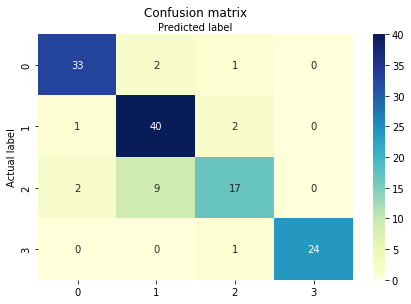

In [ ]:
class_names=['Awareness','Irrelevant', 'Report', 'Treatment'] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

###Model 3: TfidVectoriser and SGDClassifier




In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='squared_loss', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.8257575757575758
              precision    recall  f1-score   support

   Awareness       0.85      0.92      0.88        36
  Irrelevant       0.80      0.81      0.80        43
      Report       0.70      0.57      0.63        28
   Treatment       0.96      1.00      0.98        25

    accuracy                           0.83       132
   macro avg       0.82      0.83      0.82       132
weighted avg       0.82      0.83      0.82       132



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:169: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  FutureWarning,
